In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.dummy import DummyClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.random import set_seed

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.decomposition import PCA

from scipy.stats import uniform, loguniform, randint

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler
import pickle

In [2]:
type_df = pd.read_csv('../data/csv/ShakespeareCharacterLines_play_corpus.csv', index_col = ['play'])

In [3]:
colon = slice(None)

- Baseline accuracy.

In [4]:
type_df['play_type'].value_counts(normalize = True)

0    0.473684
1    0.263158
2    0.263158
Name: play_type, dtype: float64

- Train/test split.

In [5]:
type_xlist = type_df.columns.tolist()
type_xlist.remove('play_type')

type_X = type_df[type_xlist]
type_y = type_df['play_type']

type_X_train, type_X_test, type_y_train, type_y_test = \
train_test_split(type_X, type_y, random_state = 42, stratify = type_y, test_size = .2)

sc = StandardScaler()

type_Xs_train = sc.fit_transform(type_X_train)
type_Xs_test = sc.transform(type_X_test)
type_Xs = sc.transform(type_X)

- PCA.

In [6]:
pca = PCA(random_state=42)
type_Z_train = pca.fit_transform(type_Xs_train)

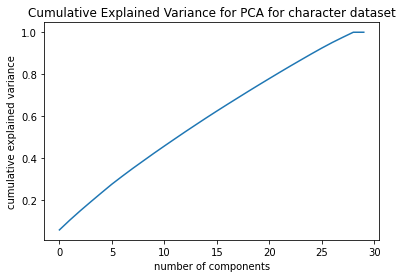

In [7]:
explained_variance = pca.explained_variance_ratio_
plt.plot(np.cumsum(explained_variance))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Cumulative Explained Variance for PCA for character dataset')
plt.show()

In [8]:
type_pca = PCA(random_state=42, svd_solver='full')
type_Z_train = type_pca.fit_transform(type_Xs_train)
type_Z_test = type_pca.transform(type_Xs_test)
type_Z = type_pca.transform(type_Xs)

- MNBchar

In [9]:
type_mnb_pipe = MultinomialNB(fit_prior = False)

type_mnb_params = {
    'alpha': uniform(0, 1)
}

type_mnb_rs = RandomizedSearchCV(estimator = type_mnb_pipe,
                     param_distributions = type_mnb_params,
                     scoring = 'roc_auc',
                     n_iter = 50,
                     n_jobs = 8,
                     cv = 5,
                     refit = True,
                     random_state=42)

In [10]:
type_mnb_rs.fit(type_X_train, type_y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=MultinomialNB(fit_prior=False), n_iter=50,
                   n_jobs=8,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002597A21DCA0>},
                   random_state=42, scoring='roc_auc')

In [11]:
train_preds = type_mnb_rs.best_estimator_.predict_proba(type_X_train)
test_preds = type_mnb_rs.best_estimator_.predict_proba(type_X_test)

metrics.roc_auc_score(type_y_train, train_preds, multi_class='ovo'), \
metrics.roc_auc_score(type_y_test, test_preds, multi_class='ovo')

(1.0, 0.8229166666666666)

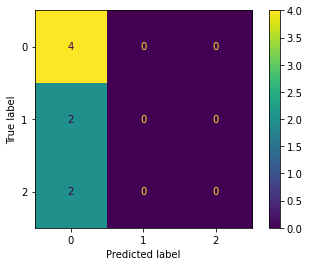

In [12]:
plot_confusion_matrix(type_mnb_rs.best_estimator_, type_X_test, type_y_test)

In [13]:
pickle.dump(type_mnb_rs.best_estimator_, open('../models/TypeMultinomialNaiveBayes.pkl', 'wb'))

- Char logreg pipe.

In [14]:
logreg_pipe = Pipeline([
    ('sc', StandardScaler()),
    ('logreg', LogisticRegression(random_state = 42, solver = 'saga'))
])

logreg_params = {
    'logreg__penalty': ['l2', 'elastic-net'],
    'logreg__tol': uniform(0, .1),
    'logreg__C': loguniform(0.0001, 100),
    'logreg__class_weight': ['balanced', None],
    'logreg__max_iter': randint(1, 1000),
    'logreg__l1_ratio': uniform(0, 1)
}

logreg_rs_rocauc = RandomizedSearchCV(estimator = logreg_pipe,
                     param_distributions = logreg_params,
                     scoring = 'roc_auc',
                     n_iter = 50,
                     n_jobs = 8,
                     cv = 5,
                     refit = True,
                     random_state=42)

In [15]:
%%time
logreg_rs_rocauc.fit(type_Xs_train, type_y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "


Wall time: 21.8 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('sc', StandardScaler()),
                                             ('logreg',
                                              LogisticRegression(random_state=42,
                                                                 solver='saga'))]),
                   n_iter=50, n_jobs=8,
                   param_distributions={'logreg__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000259006D4CD0>,
                                        'logreg__class_weight': ['balanced',
                                                                 None],
                                        'logreg__l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000259006D3040>,
                                        'logreg__max_iter': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000259006D4D60>,
                                        'logreg__penalty': ['l2',
                          

In [16]:
train_preds = logreg_rs_rocauc.best_estimator_['logreg'].predict_proba(type_Xs_train)
test_preds = logreg_rs_rocauc.best_estimator_['logreg'].predict_proba(type_Xs_test)

metrics.roc_auc_score(type_y_train, train_preds, multi_class='ovo'), \
metrics.roc_auc_score(type_y_test, test_preds, multi_class='ovo')

(1.0, 0.9791666666666666)

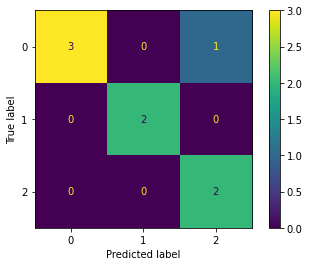

In [17]:
plot_confusion_matrix(logreg_rs_rocauc.best_estimator_['logreg'], type_Xs_test, type_y_test)

In [18]:
pickle.dump(type_mnb_rs.best_estimator_, open('../models/TypeLogisticRegression.pkl', 'wb'))

- SVC

In [19]:
svc_pipe = SVC(random_state = 42, kernel='sigmoid', probability = True)

svc_params = {
    'gamma': ['scale', 'auto'],
    'class_weight': ['balanced', None],
    'tol': loguniform(0.00001, .1),
    'C': loguniform(0.0001, 100),
    'class_weight': ['balanced', None],
    'max_iter': randint(10000, 30000)
}

svc_rs_rocauc = RandomizedSearchCV(estimator = svc_pipe,
                     param_distributions = svc_params,
                     scoring = 'roc_auc',
                     n_iter = 50,
                     n_jobs = 8,
                     cv = 5,
                     refit = True,
                     random_state=42)

In [20]:
%%time
svc_rs_rocauc.fit(type_Xs_train, type_y_train)

Wall time: 22.2 s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=SVC(kernel='sigmoid', probability=True,
                                 random_state=42),
                   n_iter=50, n_jobs=8,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000025901248CA0>,
                                        'class_weight': ['balanced', None],
                                        'gamma': ['scale', 'auto'],
                                        'max_iter': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000259006F97F0>,
                                        'tol': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000259007B29D0>},
                   random_state=42, scoring='roc_auc')

In [21]:
svc_rs_rocauc.best_estimator_

SVC(C=0.017670169402947945, class_weight='balanced', kernel='sigmoid',
    max_iter=21964, probability=True, random_state=42,
    tol=0.002440060709081752)

In [22]:
train_preds = svc_rs_rocauc.best_estimator_.predict_proba(type_Xs_train)
test_preds = svc_rs_rocauc.best_estimator_.predict_proba(type_Xs_test)

metrics.roc_auc_score(type_y_train, train_preds, multi_class='ovo'), \
metrics.roc_auc_score(type_y_test, test_preds, multi_class='ovo')

(0.0, 0.020833333333333332)

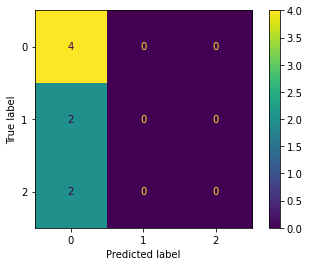

In [23]:
plot_confusion_matrix(svc_rs_rocauc.best_estimator_, type_Xs_test, type_y_test)

In [24]:
pickle.dump(svc_rs_rocauc.best_estimator_, open('../models/TypePCASVC.pkl', 'wb'))

- On to step 7 ->